In [160]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/house-prices-input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-input/sample_submission.csv
/kaggle/input/house-prices-input/data_description.txt
/kaggle/input/house-prices-input/train.csv
/kaggle/input/house-prices-input/test.csv


In [161]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [162]:
train_df = pd.read_csv('/kaggle/input/house-prices-input/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-input/test.csv')

In [163]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [164]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [165]:
train_df.dtypes[train_df.dtypes!='object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [166]:
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

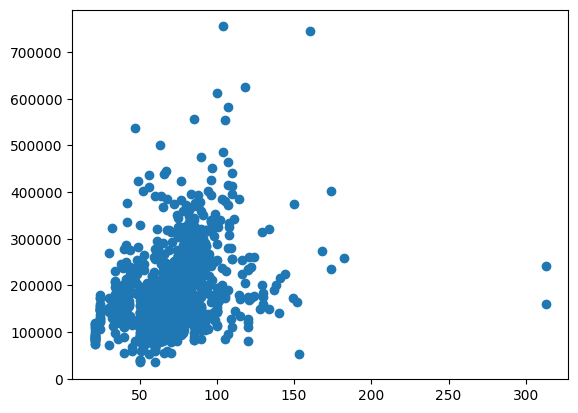

In [167]:
plt.scatter(x='LotFrontage',y='SalePrice', data=train_df)

In [168]:
train_df.query('LotFrontage>300')
#Drop 935, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


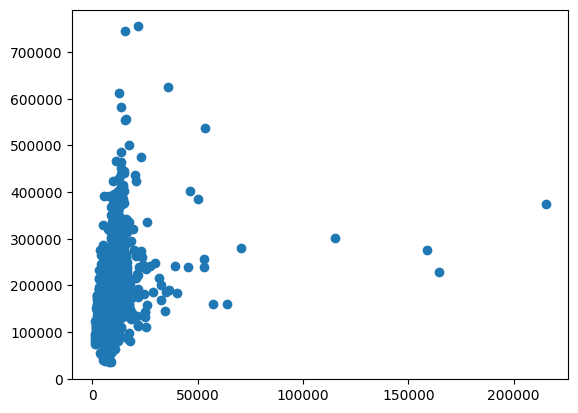

In [169]:
plt.scatter(x='LotArea',y='SalePrice', data=train_df)

In [170]:
train_df.query('LotArea>55000')
#Drop 250, 314, 336, 707

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [171]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)
# delete 313, 335, 706, 249

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

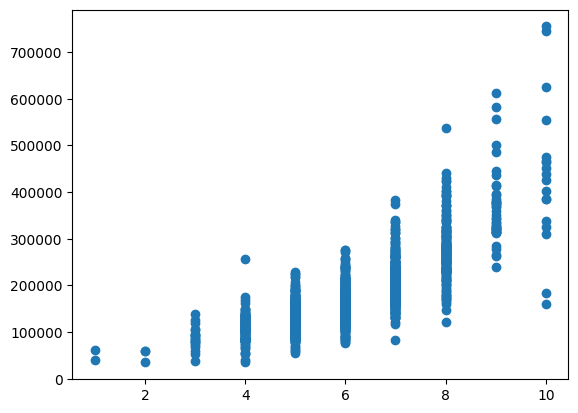

In [172]:
plt.scatter(x='OverallQual',y='SalePrice', data=train_df)

In [173]:
train_df.query('OverallQual==10 & (SalePrice<200000 or SalePrice>700000)')
#Drop 524, 692, 1183, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


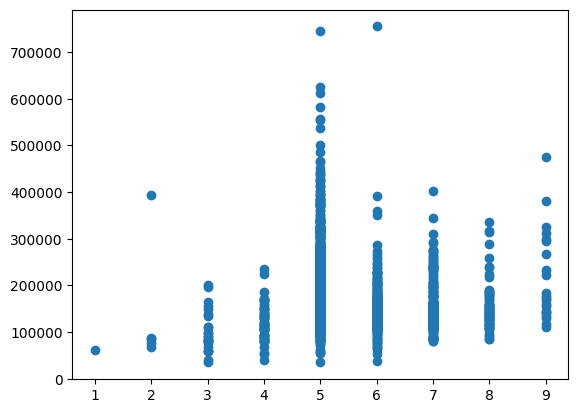

In [174]:
plt.scatter(x='OverallCond',y='SalePrice',data=train_df)

In [175]:
train_df.query('OverallCond==2  & SalePrice>300000')
#Drop 692, 1183, 379

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


In [176]:
stats.zscore(train_df['OverallCond']).sort_values().head(10)

375    -4.112970
378    -3.214027
88     -3.214027
398    -3.214027
676    -3.214027
250    -3.214027
1035   -2.315085
942    -2.315085
1223   -2.315085
344    -2.315085
Name: OverallCond, dtype: float64

In [177]:
train_df[train_df['OverallCond']==6][train_df['SalePrice']>700000]
#delete 379, 692

/tmp/ipykernel_33/2392874537.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[train_df['OverallCond']==6][train_df['SalePrice']>700000]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


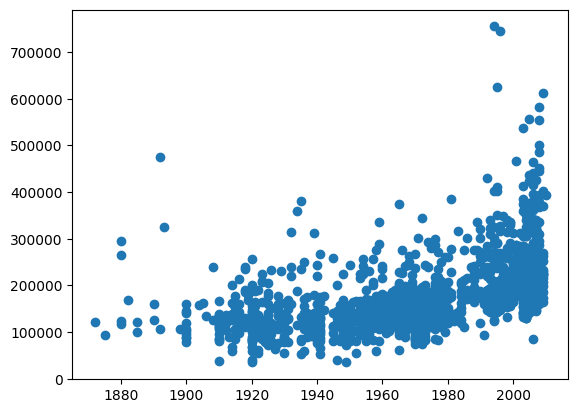

In [178]:
plt.scatter(x='YearBuilt',y='SalePrice',data=train_df)

In [179]:
train_df.query('YearBuilt<1900 & SalePrice>400000')
#Drop 692, 1183, 186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


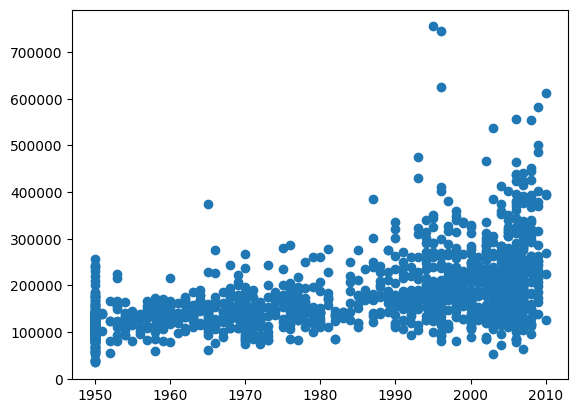

In [180]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [181]:
#in the same way look for all other outliers and construct a values vector
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [182]:
#delete outlier instances
train_df = train_df[train_df.Id.isin(values) == False]

In [183]:
#create a dataframe of null values (that are present in the train_df)
train_df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1435
MiscFeature     1388
Alley           1350
Fence           1162
MasVnrType       861
FireplaceQu      684
LotFrontage      255
GarageYrBlt       76
GarageCond        76
GarageType        76
GarageFinish      76
GarageQual        76
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

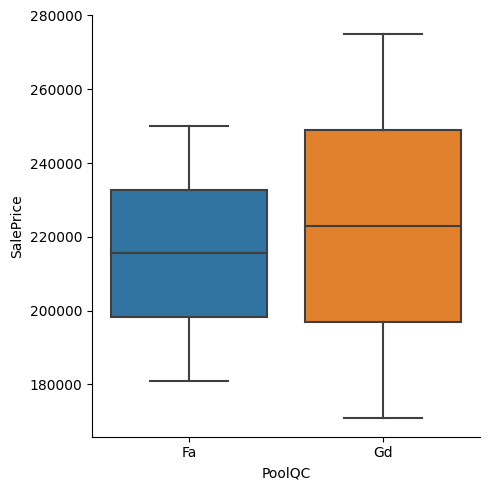

In [184]:
sns.catplot(data=train_df, x="PoolQC", y="SalePrice", kind="box")

/tmp/ipykernel_33/1315140780.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['PoolQC'].fillna('No', inplace=True)
/tmp/ipykernel_33/1315140780.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

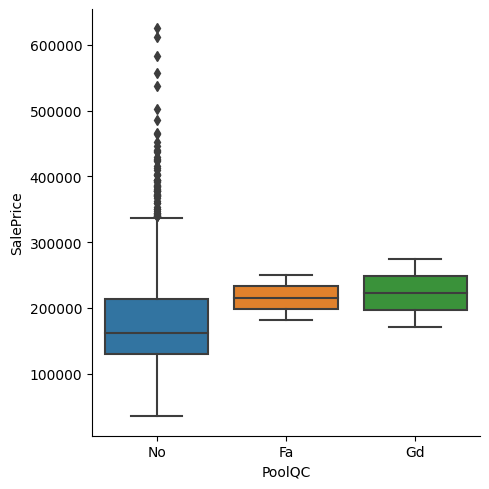

In [185]:
train_df['PoolQC'].fillna('No', inplace=True)
test_df['PoolQC'].fillna('No', inplace=True)
sns.catplot(data=train_df, x="PoolQC", y="SalePrice", kind="box")

/tmp/ipykernel_33/2883929019.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Alley'].fillna('No', inplace=True)
/tmp/ipykernel_33/2883929019.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

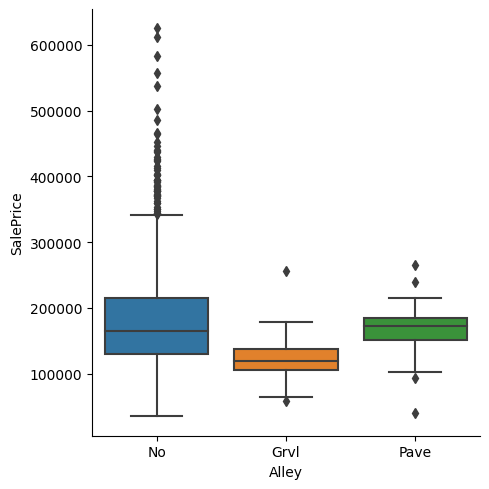

In [186]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Alley", y="SalePrice", kind="box")

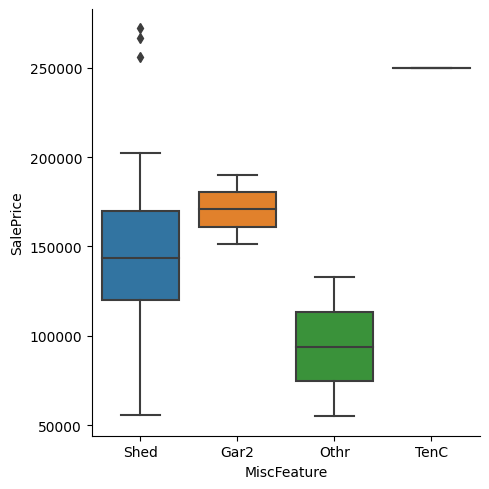

In [187]:
sns.catplot(data=train_df, x="MiscFeature", y="SalePrice", kind="box")

/tmp/ipykernel_33/2617786141.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MiscFeature'].fillna('No', inplace=True)
/tmp/ipykernel_33/2617786141.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

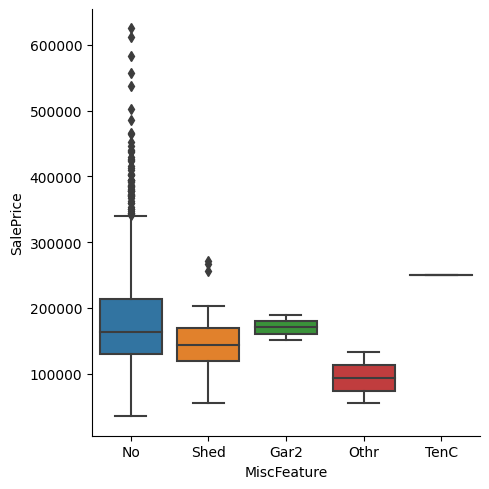

In [188]:
train_df['MiscFeature'].fillna('No', inplace=True)
test_df['MiscFeature'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="MiscFeature", y="SalePrice", kind="box")

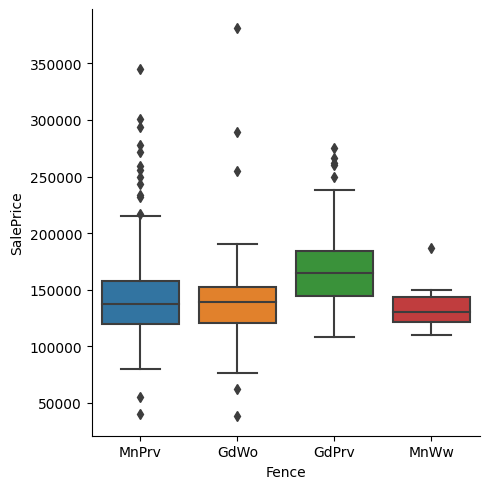

In [189]:
sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

/tmp/ipykernel_33/1471724251.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Fence'].fillna('No', inplace=True)
/tmp/ipykernel_33/1471724251.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

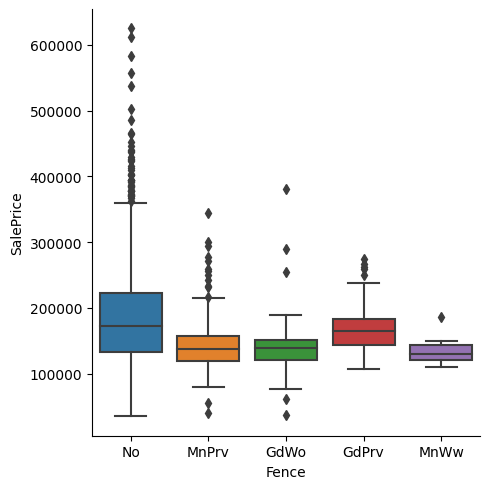

In [190]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

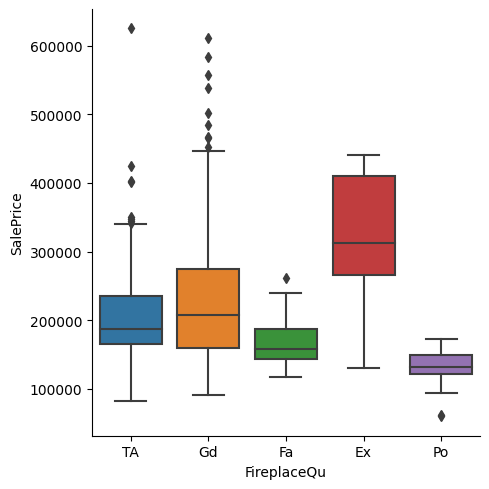

In [191]:


sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

/tmp/ipykernel_33/1967690334.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['FireplaceQu'].fillna('No', inplace=True)
/tmp/ipykernel_33/1967690334.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

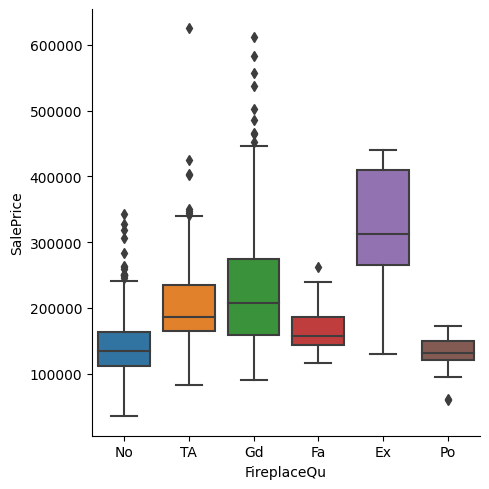

In [192]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

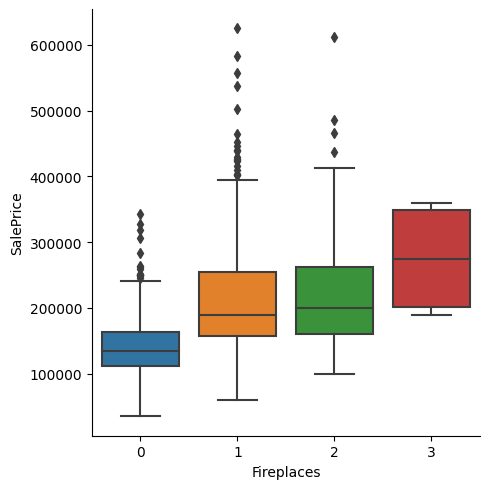

In [193]:

sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

/tmp/ipykernel_33/3906768280.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Fireplaces'].fillna('No', inplace=True)
/tmp/ipykernel_33/3906768280.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

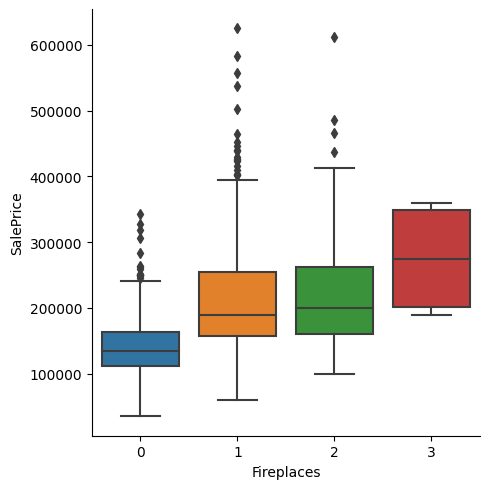

In [194]:
train_df['Fireplaces'].fillna('No', inplace=True)
test_df['Fireplaces'].fillna('No', inplace=True)

sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

In [195]:
train_df['Fireplaces'].isnull().sum()

0

In [196]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [197]:
"""
in the same way drop these too bc they have too many null/na values

MasVnrType       861
FireplaceQu      684
LotFrontage      255
"""

'\nin the same way drop these too bc they have too many null/na values\n\nMasVnrType       861\nFireplaceQu      684\nLotFrontage      255\n'

In [198]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

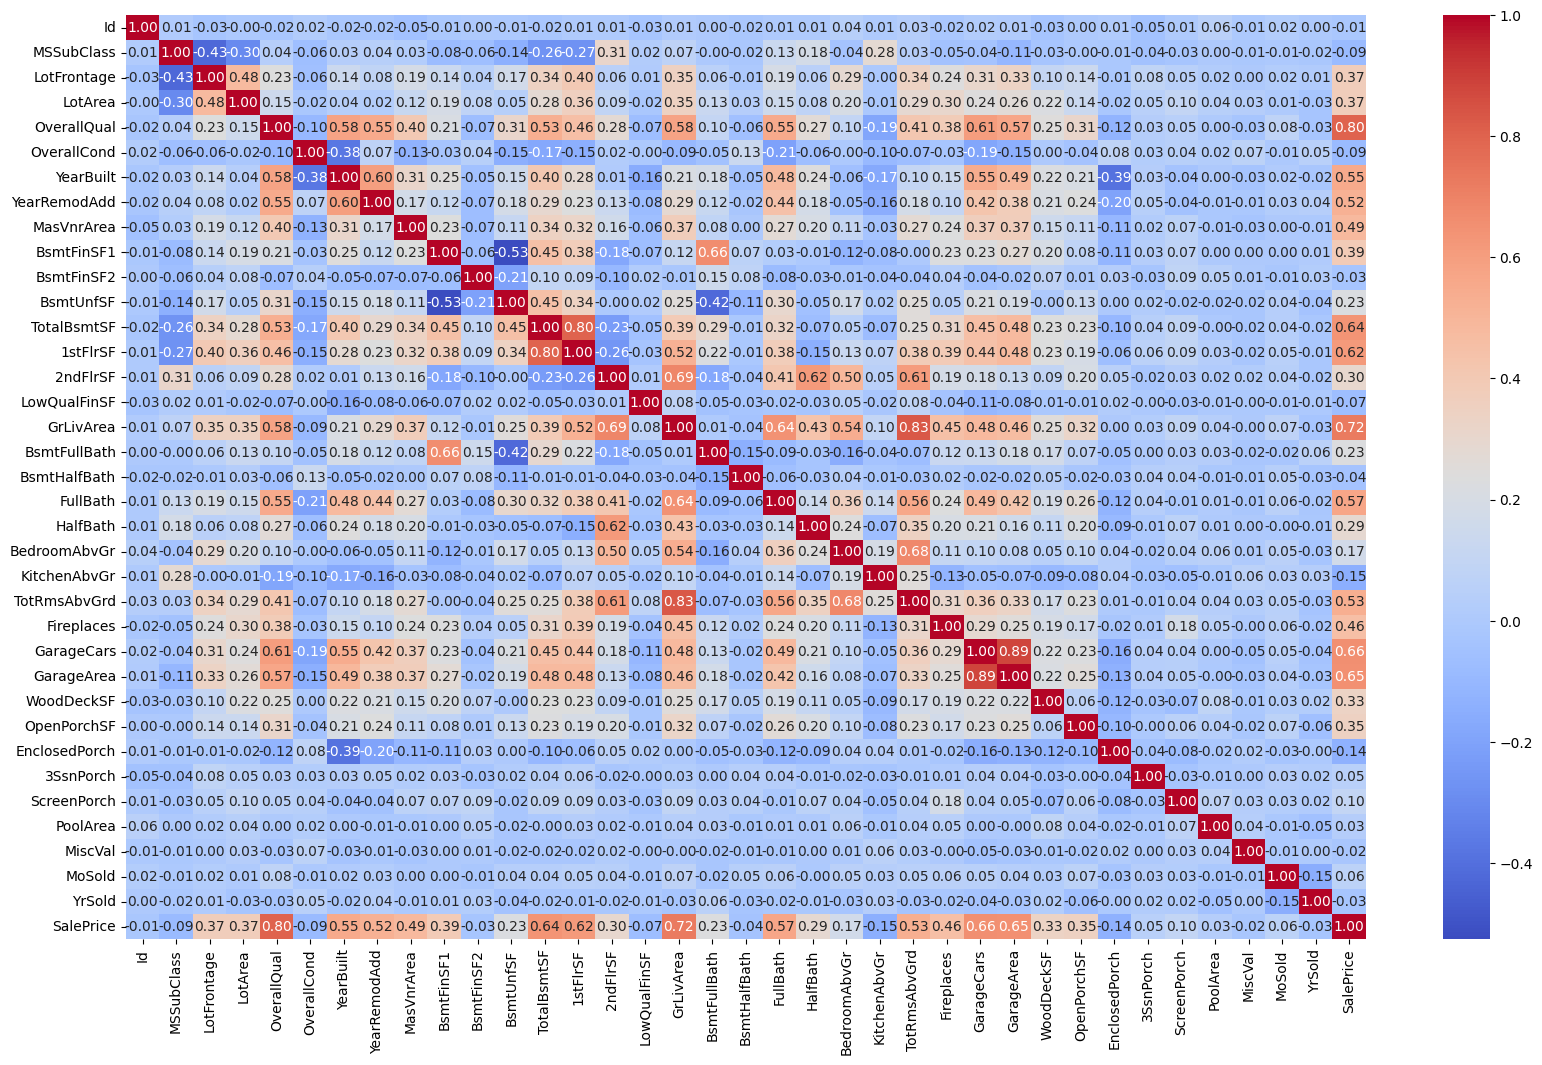

In [199]:
#let's drop some highly correlated features here (we will drop more of those too along the way)
matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.savefig('seaborn_plot.png')

In [200]:
#GarageArea and GarageCars are highly correlated with value over 0.89.
#so consider doropping one of them. both parameters together between them double their effect
#on the model

#another pair is YearBuilt and GarageYearBuilt
#TotRmsAbGrd and GrLivArea
#for that matter here are all highly correlated features:

corr_df=train_df.select_dtypes(include=np.number)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n):
    corr = df.corr()
    au_corr = corr.unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(key=lambda x: x.abs(), ascending=False)
    return au_corr[0:n]

print("Top Correlations (Positive and Negative)")
print(get_top_correlations(corr_df, 4))


Top Correlations (Positive and Negative)
GarageCars   GarageArea      0.885534
GrLivArea    TotRmsAbvGrd    0.831634
TotalBsmtSF  1stFlrSF        0.801055
OverallQual  SalePrice       0.800050
dtype: float64


In [201]:
'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'

('PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'GarageYrBlt',
 'GarageCond',
 'BsmtFinType2')

In [202]:
train_df = train_df.drop(columns=['GarageCars', 'TotRmsAbvGrd'])
test_df = test_df.drop(columns=['GarageCars', 'TotRmsAbvGrd'])

In [203]:
#if error above, it's bc the cell was run twice. no worries

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

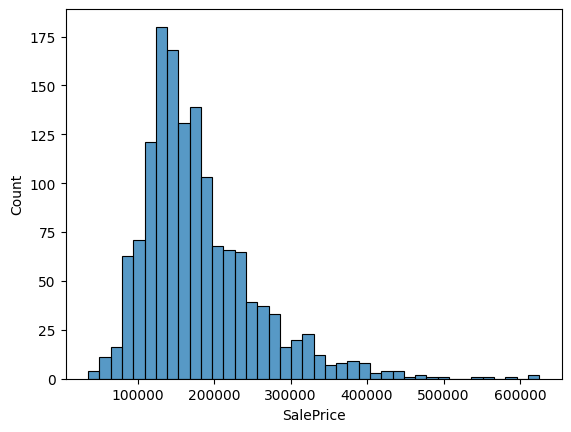

In [204]:
#take a look at price distribution
sns.histplot(train_df, x=train_df['SalePrice'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

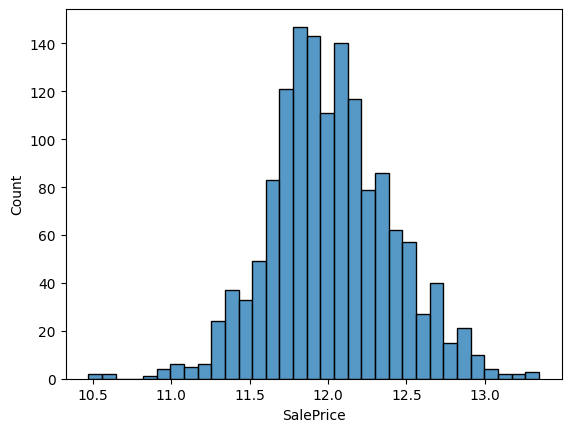

In [205]:
#apply log to sales price to normalize it
train_df['SalePrice']=np.log1p(train_df['SalePrice'])
sns.histplot(train_df, x=train_df['SalePrice'])

### turning qualititative columns into quantititative ones using ordinal and one hot encoding

In [206]:
#numerical data
train_df.dtypes[train_df.dtypes!='object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
Fireplaces         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [207]:
#categorical data
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

### get categorical colums and sort by encoding columns
- ordinal encoding for ordinal categorical data like slope(mod, steep, severe)
- one hot encoding for non-ordinal cat data like hair color (red, pink, green)

In [208]:
obj_cols = train_df.select_dtypes(include=['object']).columns
obj_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [209]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [210]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [211]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [212]:
num_cols=num_cols.drop('SalePrice')

### pipelines

In [213]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [214]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [215]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### column transformer

In [216]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [217]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [243]:
train_df['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1439, dtype: float64

In [244]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [245]:
X_preprocessed = pipeline.fit_transform(X)

In [246]:
X_preprocessed.shape

(1439, 204)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

## models

In [248]:
lr = LinearRegression()

In [249]:
lr.fit(X_train, y_train)

LinearRegression()

In [250]:
y_pred_lr = lr.predict(X_test)

In [251]:
mean_squared_error(y_test, y_pred_lr)

6.286353752601454e+17

In [253]:
RFR = RandomForestRegressor(random_state=13)

In [254]:
param_grid_RFR = {
    'max_depth': [5,10,15],
    'n_estimators': [100,250,500],
    'min_samples_split': [3,5,10]
}

In [255]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=1)

In [ ]:
rfr_cv.fit(X_train, y_train)

In [ ]:
np.sqrt(-1*rfr_cv.best_score_)

In [239]:
XGB = XGBRegressor(random_state=13)

In [240]:
param_grid_XGB= {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [241]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [242]:
xgb_cv.fit(X_train, y_train)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7eac3099ce50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 589, in _next_wrapper


KeyboardInterrupt: 